# Getting started with Bifrost

Once Bifrost is installed you can load the Python API with:

In [ ]:
%%bash
# @title Build and install
export LD_LIBRARY_PATH=/usr/local/lib:${LD_LIBRARY_PATH}
if python -c 'import bifrost' 2>/dev/null; then
    echo "Great, bifrost import seems to work."
    exit 0
else
    if python -c 'import google.colab' 2>/dev/null; then
        echo "No bifrost but we're on Google Colab, so will try to install."
    else
        echo "Sorry, please use a runtime with access to Bifrost."
        exit 1
    fi
fi
sudo apt-get -qq install exuberant-ctags libopenblas-dev software-properties-common build-essential
pip install -q contextlib2 pint simplejson scipy git+https://github.com/ctypesgen/ctypesgen.git
if [ ! -d ~/bifrost/.git ]; then
  git clone --branch autoconf https://github.com/ledatelescope/bifrost ~/bifrost
fi
cd ~/bifrost
./configure && make -j all && sudo make install

In [9]:
import bifrost

This loads the core parts of Bifrost and several useful functions.  The main way of interacting with Bifrost is through the `bifrost.ndarray`, a sub-class of `numpy.ndarray`.  You can create an empty array with:

In [11]:
data = bifrost.ndarray(shape=(2,4096), dtype='f32', space='system')
print(type(data), data.dtype, data.shape, data.bf.space)
print(data)

<class 'bifrost.ndarray.ndarray'> float32 (2, 4096) system
[[ 0.0000000e+00  0.0000000e+00 -1.8241284e+25 ...  1.5554413e-43
   1.5554413e-43  1.4012985e-43]
 [ 4.4841551e-44  1.1210388e-43  1.6955711e-43 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]


Note that bifrost defines datatypes differently to numpy:
```
f32: 32-bit float (equivalent to numpy float32)
cf32: complex 32-bit data (equivalent to numpy complex64)
i[8,16,32]: signed integer datatypes of 8, 16 and 32-bit width
u[8,16,32]: unsigned integer datatypes of 8, 16 and 32-bit width
ci[4,8,16,32]: complex 4-bit per sample, 8-bit, 16-bit and 32-bit datatypes
```

The `ci4`, `ci8` and `ci16` datatypes do not have an equivalent numpy type, but are commonly encountered in radio astronomy.

You can also use the `bifrost.ndarray` to wrap existing numpy arrays:

In [12]:
import numpy
r = numpy.random.randn(2, 4096)
data = bifrost.ndarray(r)
print(type(data), data.dtype, data.shape, data.bf.space)
print('r:', r)
print('data:', data)

<class 'bifrost.ndarray.ndarray'> float64 (2, 4096) system
r: [[ 0.17851579 -0.9965826   0.39835836 ...  0.06416343  0.7667563
  -0.53529951]
 [ 1.30749412 -1.05996732  1.20367584 ...  0.29484387 -1.37285379
  -0.45451832]]
data: [[ 0.17851579 -0.9965826   0.39835836 ...  0.06416343  0.7667563
  -0.53529951]
 [ 1.30749412 -1.05996732  1.20367584 ...  0.29484387 -1.37285379
  -0.45451832]]


Since `bifrost.ndarray`s are derived from numpy arrays they can do many (but not all) of the same things:

In [13]:
data += 2.0
print('data += 2.0:', data)
data[0,:] = 55
print('data[0,:] = 55:', data)

data += 2.0: [[2.17851579 1.0034174  2.39835836 ... 2.06416343 2.7667563  1.46470049]
 [3.30749412 0.94003268 3.20367584 ... 2.29484387 0.62714621 1.54548168]]
data[0,:] = 55: [[55.         55.         55.         ... 55.         55.
  55.        ]
 [ 3.30749412  0.94003268  3.20367584 ...  2.29484387  0.62714621
   1.54548168]]


In [14]:
data[:,[1,3,5,7]] = 10
print('data[:,[1,3,5,7]] = 10:', data)

data[:,[1,3,5,7]] = 10: [[55.         55.         55.         ... 55.         55.
  55.        ]
 [ 3.30749412  0.94003268  3.20367584 ...  2.29484387  0.62714621
   1.54548168]]


You can also use `bifrost.ndarray`s with [numba](https://numba.pydata.org/):

In [15]:
from numba import jit

@jit(nopython=True)
def compute(x):
    for i in range(len(x)):
        x[i] = x[i] + 10

compute(data)
print(type(data), data)



<class 'bifrost.ndarray.ndarray'> [[65.         65.         65.         ... 65.         65.
  65.        ]
 [13.30749412 10.94003268 13.20367584 ... 12.29484387 10.62714621
  11.54548168]]


### Arrays on the CPU and GPU

Unlike numpy arrays `bifrost.ndarray` are "space aware", meaning that they can exist in different memory spaces.  What we have created so far is in system memory.  `bifrost.ndarray`s can also exist in "cuda_host" (pinned) memory and "cuda" (GPU) memory:

In [16]:
data2 = bifrost.ndarray(shape=(2,4096), dtype='f32', space='cuda_host')
data3 = bifrost.ndarray(shape=(2,4096), dtype='f32', space='cuda')
print(type(data2), data2.dtype, data2.shape, data2.bf.space)
print(type(data3), data3.dtype, data3.shape, data3.bf.space)

<class 'bifrost.ndarray.ndarray'> float32 (2, 4096) cuda_host
<class 'bifrost.ndarray.ndarray'> float32 (2, 4096) cuda


To move between the different spaces the `bifrost.ndarray` class provides a `copy` method:

In [17]:
data4 = data.copy(space='cuda')
print(type(data4), data4.dtype, data4.shape, data4.bf.space)

<class 'bifrost.ndarray.ndarray'> float64 (2, 4096) cuda


Once on the GPU you can take advantage of Bifrost's GPU-based functions, like `bifrost.map`:

In [18]:
bifrost.map("a(i,j) *= 10",
            {'a': data4},
            axis_names=('i', 'j'),
            shape=data4.shape)
data4 = data4.copy(space='system')
print('data4/data = data*10/data = 10:', data4/data)

data4/data = data*10/data = 10: [[10. 10. 10. ... 10. 10. 10.]
 [10. 10. 10. ... 10. 10. 10.]]


The `bifrost.map` call here compiles and runs a CUDA kernel that does an element-wise multiplication by ten.  In order to view the results of this kernel call we need to copy the memory back to the "system" memory space.  In the future we hope to support a "cuda_managed" space to make this easier.

`bifrost.map` is an example of a function that does not require any additional setup to run. This code is converted into a CUDA kernel at runtime, using [NVRTC](https://docs.nvidia.com/cuda/nvrtc/index.html). 

For some Bifrost functions, like `bifrost.fft.Fft`, some setup is required so that the function knows how to run. To show the use of the Bifrost FFT, let us first make some example data on the GPU, using `bf.map`:

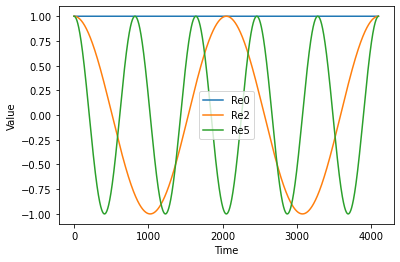

In [21]:
data = bifrost.ndarray(shape=(16, 4096), dtype='cf32', space='cuda')
bifrost.map("a(i,j) = exp(Complex<float>(0.0, 2*3.14*i*j/4096))",
            {'a': data},
            axis_names=('i', 'j'),
            shape=data.shape)
data2 = data.copy(space='system')

import pylab
pylab.plot(data2[0,:].real, label='Re0')
#pylab.plot(data2[0,:].imag, label='Im0')
pylab.plot(data2[2,:].real, label='Re2')
#pylab.plot(data2[2,:].imag, label='Im2')
pylab.plot(data2[5,:].real, label='Re5')
#pylab.plot(data2[5,:].imag, label='Im5')
pylab.xlabel('Time')
pylab.ylabel('Value')
pylab.legend(loc=0)

Now run the FFT and plot the results. The FFT is initialised using its `.init` method, and then executed using its `.execute` method.  An output data array also needs to be pre-allocated :

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


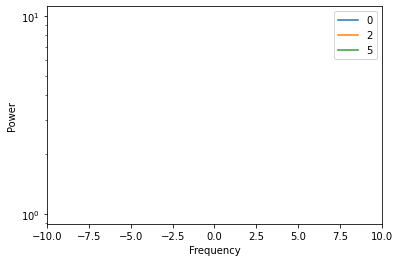

In [22]:
fdata = bifrost.ndarray(shape=data.shape, dtype='cf32', space='cuda')
f = bifrost.fft.Fft()
f.init(data, fdata, axes=1, apply_fftshift=True)
f.execute(data, fdata)
fdata2 = fdata.copy(space='system')
ffreqs = numpy.fft.fftfreq(fdata2.shape[1], d=1/4096.)
ffreqs = numpy.fft.fftshift(ffreqs)

pylab.semilogy(ffreqs, numpy.abs(fdata2[0,:])**2, label='0')
pylab.semilogy(ffreqs, numpy.abs(fdata2[2,:])**2, label='2')
pylab.semilogy(ffreqs, numpy.abs(fdata2[5,:])**2, label='5')
pylab.xlabel('Frequency')
pylab.ylabel('Power')
pylab.xlim(-10, 10)
pylab.legend(loc=0)